# Multivariate Hypergeometric Distribution

There are $K_i$ balls of color $i$.

There are $c$ distinct colors (contients of residence), thus, $i=1, 2, \cdots, 3$. So, the total number of balls is
$$N = \sum_{i=1}^c K_i$$
All $N$ of these balls are placed in urn and n balls are drawn randomly. 

The selection procedure is supposed to be __color blind__. Let $k_i$ be the number of balls of colors $i$ that are drawn. Things have to be add up, so the constrain should be:
$$\sum_{i=1}^c k_i = n$$
There the outcome should be a random vector:
\begin{align}
X = \begin{pmatrix}
k_1 \\
k_2 \\
\vdots \\
k_c 
\end{pmatrix}
\end{align}

To evaluate whether the selection procedure is color blind the administrator wants to study whether the particular realization of X drawn can plausibly be said to be a random draw from the probability distribution that is implied by the __color blind__ hypothesis. 

Here are parameters:

* $N = 238$
* blue balls: 157, green ones, yellow ones and black ones are 11, 46, 24
* n = 15

In [2]:
import numpy as np
from scipy.special import comb
from scipy.stats import normaltest
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

In [15]:
class Urn:

    def __init__(self, K_arr):
        self.K_arr = np.array(K_arr)
        self.N = np.sum(K_arr)
        self.c = len(K_arr)

    def pmf(self, k_arr):
        # K_arr is the array of total balls in differnt colors
        # k_arr is the number of balls we choose
        K_arr, N = self.K_arr, self.N
        k_arr = np.atleast_2d(k_arr)
        n = np.sum(k_arr, 1)

        num = np.prod(comb(K_arr, k_arr), 1)
        denom = comb(N, n)

        pr = num / denom

        return pr

    def moments(self, n):
        # focus on the first and second moment
        # in python 3, you could use unicode symbol like Σ as a variable
        K_arr, N, c = self.K_arr, self.N, self.c

        μ = n * K_arr / N

        Σ = np.ones((c, c)) * n * (N - n) / (N - 1) / N ** 2
        for i in range(c-1):
            Σ[i, i] *= K_arr[i] * (N-K_arr[i])
            for j in range(i+1, c):
                Σ[i, j] *= - K_arr[i] * K_arr[j]
                Σ[j, i] = Σ[i, j]

            Σ[-1, -1] *= K_arr[-1] * (N - K_arr[-1])

        return μ, Σ
    
    def simulate(self, n, size=1, seed=None):
        K_arr = self.K_arr
        gen = np.random.Generator(np.random.PCG64(seed))
        sample = gen.multivariate_hypergeometric(K_arr, n, size=size)

        return sample


In [16]:
K_arr = [5, 10, 15]
urn = Urn(K_arr)
k_arr = [2, 2, 2] # array of number of chose
urn.pmf(k_arr)

array([0.0795756])

In [17]:
# two dimensions
k_arr = [[2, 2, 2], [1, 3, 2]]  # n = 6, for each session
urn.pmf(k_arr)

array([0.0795756, 0.1061008])

In [18]:
n = 6
μ, Σ = urn.moments(n)

In [19]:
μ

array([1., 2., 3.])

In [20]:
Σ

array([[ 6.89655172e-01, -2.75862069e-01, -4.13793103e-01],
       [-2.75862069e-01,  1.10344828e+00, -8.27586207e-01],
       [-4.13793103e-01, -8.27586207e-01,  2.79310345e+02]])

In [21]:
K_arr = [157, 11, 46, 24]
urn = Urn(K_arr)
k_arr = [10, 1, 4, 0]
print(urn.pmf(k_arr))
k_arr = [[5, 5, 4 ,1], [10, 1, 2, 2], [13, 0, 2, 0]]
print(urn.pmf(k_arr))

[0.01547738]
[6.21412534e-06 2.70935969e-02 1.61839976e-02]


In [24]:
n = 6
mu, sigma = urn.moments(n)
mu

array([3.95798319, 0.27731092, 1.15966387, 0.60504202])

In [23]:
sigma

array([[ 1.31862604e+00, -1.79072672e-01, -7.48849354e-01,
        -3.90704011e-01],
       [-1.79072672e-01,  2.58913990e-01, -5.24671522e-02,
        -2.73741663e-02],
       [-7.48849354e-01, -5.24671522e-02,  9.15790292e-01,
        -1.14473787e-01],
       [-3.90704011e-01, -2.73741663e-02, -1.14473787e-01,
         1.40479198e+07]])

In [25]:
size = 10_000_000
sample = urn.simulate(n, size=size)
np.mean(sample, 0)

array([3.9582139, 0.2770854, 1.1595705, 0.6051302])

In [26]:
np.cov(sample.T)

array([[ 1.31869455, -0.1787421 , -0.74903205, -0.39092041],
       [-0.1787421 ,  0.25879051, -0.05253186, -0.02751655],
       [-0.74903205, -0.05253186,  0.91592025, -0.11435634],
       [-0.39092041, -0.02751655, -0.11435634,  0.53279329]])

### Quality of Normal Approximation

To judge the quality of a multivariate normal approximation to the multivariate hypergeometric distribution, we draw a large sample from a multivariate normal distribution with the mean vector and covariance matrix for the corresponding multivariate hypergeometric distribution and compare the simulated distribution with the population multivariate hypergeometric distribution.

In [27]:
sample_normal = np.random.multivariate_normal(mu, sigma, size=size)

In [28]:
def bivariate_normal(x, y, μ, Σ, i, j):

    μ_x, μ_y = μ[i], μ[j]
    σ_x, σ_y = np.sqrt(Σ[i, i]), np.sqrt(Σ[j, j])
    σ_xy = Σ[i, j]

    x_μ = x - μ_x
    y_μ = y - μ_y

    ρ = σ_xy / (σ_x * σ_y)
    z = x_μ**2 / σ_x**2 + y_μ**2 / σ_y**2 - 2 * ρ * x_μ * y_μ / (σ_x * σ_y)
    denom = 2 * np.pi * σ_x * σ_y * np.sqrt(1 - ρ**2)

    return np.exp(-z / (2 * (1 - ρ**2))) / denom

In [29]:
@njit
def count(vec1, vec2, n):
    size = sample.shape[0]

    count_mat = np.zeros((n+1, n+1))
    for i in prange(size):
        count_mat[vec1[i], vec2[i]] += 1

    return count_mat

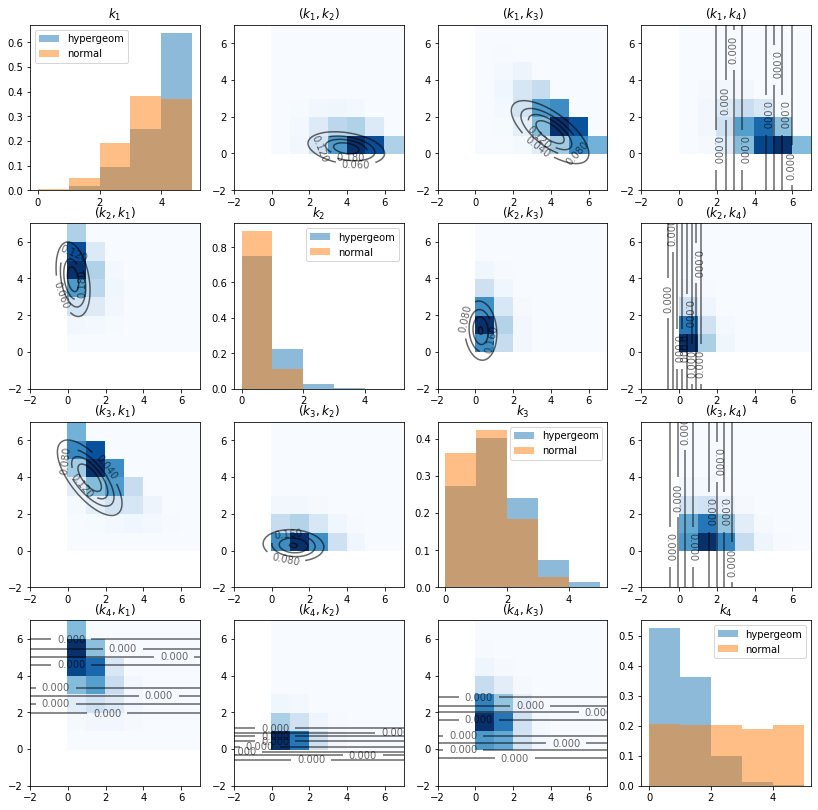

In [31]:
c = urn.c
fig, axs = plt.subplots(c, c, figsize=(14, 14))

# grids for ploting the bivariate Gaussian
x_grid = np.linspace(-2, n+1, 100)
y_grid = np.linspace(-2, n+1, 100)
X, Y = np.meshgrid(x_grid, y_grid)

for i in range(c):
    axs[i, i].hist(sample[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='hypergeom')
    axs[i, i].hist(sample_normal[:, i], bins=np.arange(0, n, 1), alpha=0.5, density=True, label='normal')
    axs[i, i].legend()
    axs[i, i].set_title('$k_{' +str(i+1) +'}$')
    for j in range(c):
        if i == j:
            continue

        # bivariate Gaussian density function
        Z = bivariate_normal(X, Y, mu, sigma, i, j)
        cs = axs[i, j].contour(X, Y, Z, 4, colors="black", alpha=0.6)
        axs[i, j].clabel(cs, inline=1, fontsize=10)

        # empirical multivariate hypergeometric distrbution
        count_mat = count(sample[:, i], sample[:, j], n)
        axs[i, j].pcolor(count_mat.T/size, cmap='Blues')
        axs[i, j].set_title('$(k_{' +str(i+1) +'}, k_{' + str(j+1) + '})$')

plt.show()

In [32]:
test_multihyper = normaltest(sample)
test_multihyper.pvalue

array([0., 0., 0., 0.])

In [33]:
test_normal = normaltest(sample_normal)
test_normal.pvalue

array([0.13670362, 0.43322312, 0.25624747, 0.61951523])

The lesson to take away from this is that the __normal approximation is imperfect__ as

* the sample is drawn from the multivariate hypergeometric distribution based on `urn.simulate`
* use the first and second moments to generate the sample again with the function `np.random.multivariate_normal(mu, sigma, size=size)`
* normality test will pass for `multivariate_normal` but not the sample from the simulation.